# 6. EDA (Exploratory Data Analysis) and Feature Selection

## Overview
In this notebook, to improve the accuracy of the electricity demand and solar power generation forecasting model, we will add weather data and calendar information as external features, and perform exploratory data analysis (EDA) and feature selection.

### 6-1. Objective

The objective of this notebook is to identify external features that contribute to improving the accuracy of predictive models.

The baseline model constructed in the previous step used only past time-series patterns for training. As a result, while a certain level of accuracy was achieved for electricity consumption prediction, the accuracy for solar power generation prediction, which strongly depends on external factors such as weather, was insufficient.

To address this issue, this step will add new weather data and calendar information as features and analyze their relationships with the target variables (power generation/consumption). Based on the insights gained through the analysis, effective features for model training will be selected using the following multi-faceted approaches:

1.  **Correlation Analysis**: Evaluate the linear relationship between each feature and the target variable to understand the overall picture.
2.  **LASSO Regression**: Use L1 regularization to zero out coefficients of features with small contributions to prediction, thereby identifying effective variables while avoiding multicollinearity.
3.  **Visualization of LASSO Regularization Path**: Visualize the relationship between regularization strength ($\alpha$), model error, and the number of selected features to validate the variable selection process.
4.  **LightGBM + SHAP**: Build a LightGBM model capable of capturing non-linear relationships using the features selected by LASSO. Evaluate the magnitude and direction (positive/negative) of each feature's influence on predictions using SHAP values to deepen interpretability.

## 6-2. Data Preparation

### 6-2-1. Data Sources
The data used in this analysis are as follows.

- **Electricity Supply-Demand Data**:
    - Provider: TEPCO Power Grid
    - Content: 30-minute actual electricity supply and demand in the TEPCO Power Grid area.
    - URL: [https://www.tepco.co.jp/pg/consignment/results/supply-demand.html](https://www.tepco.co.jp/pg/consignment/results/supply-demand.html)

- **Weather Data**:
    - Provider: Japan Meteorological Agency
    - Content: Tokyo's weather observation data (temperature, precipitation, sunshine duration, etc.).
    - URL: [https://www.data.jma.go.jp/gmd/risk/obsdl/](https://www.data.jma.go.jp/gmd/risk/obsdl/)

#### Supplementary Data Description

* Note that while weather information is unpredictable, periodic functions and holidays can be anticipated.

* Weather Data Column Names - Japanese
"Pressure (Local)","Pressure (Sea Level)","Precipitation","Temperature","Dew Point","Vapor Pressure",
 "Humidity","Wind Speed","Wind Direction","Sunshine Duration","Global Solar Radiation","Snowfall","Snow Depth",

* Weather Data Column Names (English) (unnecessary columns removed)
"pressure_local", "pressure_sea", "precipitation", "temperature", "dew_point", "vapor_pressure", "humidity", "wind_speed", "sunshine_duration", "solar_radiation"									

* Hourly weather data is linearly interpolated and processed for use at 30-minute intervals.

    ```python
    df.resample('30T').interpolate(method='linear')
    ```

In [1]:
# Import libraries

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm.notebook import tqdm
import itertools
import warnings

# Import common modules
from src.data_utils import load_timeseries_data, validate_no_missing

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['font.family'] = 'Meiryo' # For Windows. For Mac, use 'Hiragino Sans' or similar.

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)
df.head()

,solar_gen_mw,e_demand_mw
datetime,,
2023-01-01 00:00:00,0,29870
2023-01-01 00:30:00,0,28640
2023-01-01 01:00:00,0,27560
2023-01-01 01:30:00,0,27240
2023-01-01 02:00:00,0,26650


In [3]:
# Load weather data and check for missing values
weather_csv = DATA_DIR / "weather_data.csv"
dfw = load_timeseries_data(weather_csv)
validate_no_missing(dfw)
dfw.head()

Missing value check completed: No missing values in any column


,pressure_local,precipitation,temperature,dew_point,vapor_pressure,humidity,wind_speed,sunshine_duration,solar_radiation
datetime,,,,,,,,,
2023-01-01 00:00:00,1018.20,0.0,3.80,-0.60,5.9,73.0,1.80,0.0,0.0
2023-01-01 00:30:00,1018.05,0.0,3.65,-0.55,5.9,74.0,1.40,0.0,0.0
2023-01-01 01:00:00,1017.90,0.0,3.50,-0.50,5.9,75.0,1.00,0.0,0.0
2023-01-01 01:30:00,1018.00,0.0,3.35,-0.75,5.8,74.5,1.15,0.0,0.0
2023-01-01 02:00:00,1018.10,0.0,3.20,-1.00,5.7,74.0,1.30,0.0,0.0


In [4]:
if 'pressure_sea' in dfw.columns:
    weather_data = dfw.drop(columns=['pressure_sea'])
else:
    # If the column is not present, use the original DataFrame.
    weather_data = dfw.copy() 
    
# Save the results as a CSV file.
weather_data.to_csv('../data/weather_data.csv', encoding='utf-8')

### 6-2-2. Feature Engineering

To enhance the expressiveness of the prediction model, the following features will be created:

-   **Periodicity Features**: To make it easier for the model to learn the periodicity of time and weekdays, features created by `sin/cos` transforming `hour` and `weekday` (`sin_hour`, `cos_hour`, `sin_weekday`, `cos_weekday`) will be created.
-   **Holiday Features**: Based on holiday data provided by the Cabinet Office, a flag (`is_holiday`) will be created that defines weekends, national holidays, and year-end/New Year holidays as "holidays".

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, date

def create_extended_holiday_feature(df):
 # Get holiday data
 holiday_df = pd.read_csv('https://www8.cao.go.jp/chosei/shukujitsu/syukujitsu.csv',
 encoding='shift_jis',
 parse_dates=['国民の祝日・休日月日'])
 
 # Convert holiday data to a set
 holiday_dates = set(holiday_df['国民の祝日・休日月日'].dt.date)
 
 # Function to add year-end and New Year holidays
 def is_yearend_holiday(d):
    month = d.month
    day = d.day
    return ((month == 12 and day >= 30) or 
    (month == 1 and day <= 3))
 
 # Determine weekends, holidays, and year-end/New Year holidays
 df['is_holiday'] = df.index.map(lambda x: 
 1 if (x.weekday() >= 5 or 
 x.date() in holiday_dates or 
 is_yearend_holiday(x)) else 0)
 
 # Create cyclic features
 hours = df.index.hour
 df['sin_hour'] = np.sin(2 * np.pi * hours/24)
 df['cos_hour'] = np.cos(2 * np.pi * hours/24)
 
 weekdays = df.index.weekday
 df['sin_weekday'] = np.sin(2 * np.pi * weekdays/7)
 df['cos_weekday'] = np.cos(2 * np.pi * weekdays/7)
 
 # Save results
 holiday_features = df[['sin_hour', 'cos_hour', 
 'sin_weekday', 'cos_weekday', 
 'is_holiday']]
 holiday_features.to_csv('../data/sincos_holiday.csv')
 
 return df

# Execute
df_extended = create_extended_holiday_feature(df)

# Verify if year-end and New Year holidays are correctly identified
check_dates = [
 '2024-12-30', '2024-12-31', '2025-01-02', '2025-01-03'
]
print("\nYear-end and New Year Holiday Check:")
for d in check_dates:
 if d in df_extended.index:
    print(f"{d}: is_holiday = {df_extended.loc[d, 'is_holiday']}")

df_extended.head()


Year-end and New Year Holiday Check:
2024-12-30: is_holiday = datetime
2024-12-30 00:00:00    1
2024-12-30 00:30:00    1
2024-12-30 01:00:00    1
2024-12-30 01:30:00    1
2024-12-30 02:00:00    1
2024-12-30 02:30:00    1
2024-12-30 03:00:00    1
2024-12-30 03:30:00    1
2024-12-30 04:00:00    1
2024-12-30 04:30:00    1
2024-12-30 05:00:00    1
2024-12-30 05:30:00    1
2024-12-30 06:00:00    1
2024-12-30 06:30:00    1
2024-12-30 07:00:00    1
2024-12-30 07:30:00    1
2024-12-30 08:00:00    1
2024-12-30 08:30:00    1
2024-12-30 09:00:00    1
2024-12-30 09:30:00    1
2024-12-30 10:00:00    1
2024-12-30 10:30:00    1
2024-12-30 11:00:00    1
2024-12-30 11:30:00    1
2024-12-30 12:00:00    1
2024-12-30 12:30:00    1
2024-12-30 13:00:00    1
2024-12-30 13:30:00    1
2024-12-30 14:00:00    1
2024-12-30 14:30:00    1
2024-12-30 15:00:00    1
2024-12-30 15:30:00    1
2024-12-30 16:00:00    1
2024-12-30 16:30:00    1
2024-12-30 17:00:00    1
2024-12-30 17:30:00    1
2024-12-30 18:00:00    1
202

,solar_gen_mw,e_demand_mw,is_holiday,sin_hour,cos_hour,sin_weekday,cos_weekday
datetime,,,,,,,
2023-01-01 00:00:00,0,29870,1,0.000000,1.000000,-0.781831,0.62349
2023-01-01 00:30:00,0,28640,1,0.000000,1.000000,-0.781831,0.62349
2023-01-01 01:00:00,0,27560,1,0.258819,0.965926,-0.781831,0.62349
2023-01-01 01:30:00,0,27240,1,0.258819,0.965926,-0.781831,0.62349
2023-01-01 02:00:00,0,26650,1,0.500000,0.866025,-0.781831,0.62349


In [6]:
# Check for missing values and min/max dates for the two dataframes: df_extended and weather_data

dataframes = {
 'df_extended': df_extended,
 'weather_data': weather_data
}

for name, dataframe in dataframes.items():
    print(f"\nDataFrame: {name}")
    print("Missing Value Check:")
    print(dataframe.isnull().sum())
    print(f"Min Date: {dataframe.index.min()}")
    print(f"Max Date: {dataframe.index.max()}")


DataFrame: df_extended
Missing Value Check:
solar_gen_mw    0
e_demand_mw     0
is_holiday      0
sin_hour        0
cos_hour        0
sin_weekday     0
cos_weekday     0
dtype: int64
Min Date: 2023-01-01 00:00:00
Max Date: 2025-03-31 23:30:00

DataFrame: weather_data
Missing Value Check:
pressure_local       0
precipitation        0
temperature          0
dew_point            0
vapor_pressure       0
humidity             0
wind_speed           0
sunshine_duration    0
solar_radiation      0
dtype: int64
Min Date: 2023-01-01 00:00:00
Max Date: 2025-04-01 00:00:00


In [7]:
# Join aligning with df_extended's index.
df_with_x = df_extended.join(weather_data, how='left')
# Re-check missing values
print("\nMissing value check after joining:")
print(df_with_x.isnull().sum())

# Save the df 'df_with_x', which has no missing values and includes explanatory variables, to '../data'.
df_with_x.to_csv('../data/df_with_x.csv', encoding='utf-8')


Missing value check after joining:
solar_gen_mw         0
e_demand_mw          0
is_holiday           0
sin_hour             0
cos_hour             0
sin_weekday          0
cos_weekday          0
pressure_local       0
precipitation        0
temperature          0
dew_point            0
vapor_pressure       0
humidity             0
wind_speed           0
sunshine_duration    0
solar_radiation      0
dtype: int64


### 6-2-2. Creation of Shifted Target DataFrame

When using explanatory variables in time series forecasting, except for SARIMAX-like models, creating a dataframe where the target variable y is time-shifted reduces the possibility of data leakage in various stages such as training, prediction, and feature selection.

The amount of the shift is often referred to as "Forecast Horizon" or "prediction horizon."

In [8]:
# Create a DataFrame with the target variable y shifted by time (48 steps)
SHIFT_PERIOD = -48 # Bring future values to the current row (for prediction purposes)

# Shift target variables
df_with_x['solar_shifted'] = df_with_x['solar_gen_mw'].shift(SHIFT_PERIOD)
df_with_x['demand_shifted'] = df_with_x['e_demand_mw'].shift(SHIFT_PERIOD)

# Delete original target variable columns (to prevent leakage)
df_shifted = df_with_x.drop(columns=['solar_gen_mw', 'e_demand_mw'])

# Delete NaN rows at the end of the dataset generated by shift(-48)
# These rows cannot be used for training because the prediction target (shifted y) does not exist in the future
df_shifted = df_shifted.dropna(subset=['solar_shifted', 'demand_shifted'])

# Confirm number of rows after cutting missing data period
print(f"Original number of rows: {len(df_with_x)}")
print(f"Number of rows after shifting and cutting missing rows: {len(df_shifted)}")

# Reconfirm missing values
print("\nMissing value check after concatenation:")
print(df_shifted.isnull().sum())

# Save the final df
df_shifted.to_csv('../data/df_shifted.csv', encoding='utf-8')

print("\nFirst 5 rows of '../data/df_shifted.csv':")
print(df_shifted.head())

Original number of rows: 39408
Number of rows after shifting and cutting missing rows: 39360

Missing value check after concatenation:
is_holiday           0
sin_hour             0
cos_hour             0
sin_weekday          0
cos_weekday          0
pressure_local       0
precipitation        0
temperature          0
dew_point            0
vapor_pressure       0
humidity             0
wind_speed           0
sunshine_duration    0
solar_radiation      0
solar_shifted        0
demand_shifted       0
dtype: int64

First 5 rows of '../data/df_shifted.csv':
                     is_holiday  sin_hour  cos_hour  sin_weekday  cos_weekday  \
datetime                                                                        
2023-01-01 00:00:00           1  0.000000  1.000000    -0.781831      0.62349   
2023-01-01 00:30:00           1  0.000000  1.000000    -0.781831      0.62349   
2023-01-01 01:00:00           1  0.258819  0.965926    -0.781831      0.62349   
2023-01-01 01:30:00           1  0.2

## 6-3. Implementing Feature Selection

Feature selection will be performed using an analysis dataset that combines power data (target variable) with weather and cyclical data (explanatory variables).
For each of the target variables, "Solar Power Generation (solar_gen_mw)" and "Power Consumption (e_demand_mw)," the aforementioned process (Correlation Analysis → LASSO → SHAP) will be applied.

First, we will begin the analysis with "Solar Power Generation (solar_gen_mw)."

First, we will begin the analysis with "Solar Power Generation (solar_gen_mw)."

### 6-3-1. Feature Selection for Solar Power Generation (`solar_gen_mw`)

#### 6-3-1-1. Correlation Analysis

Visualize the linear correlation between the target variable and each explanatory variable using a heatmap to grasp the overall relationship.

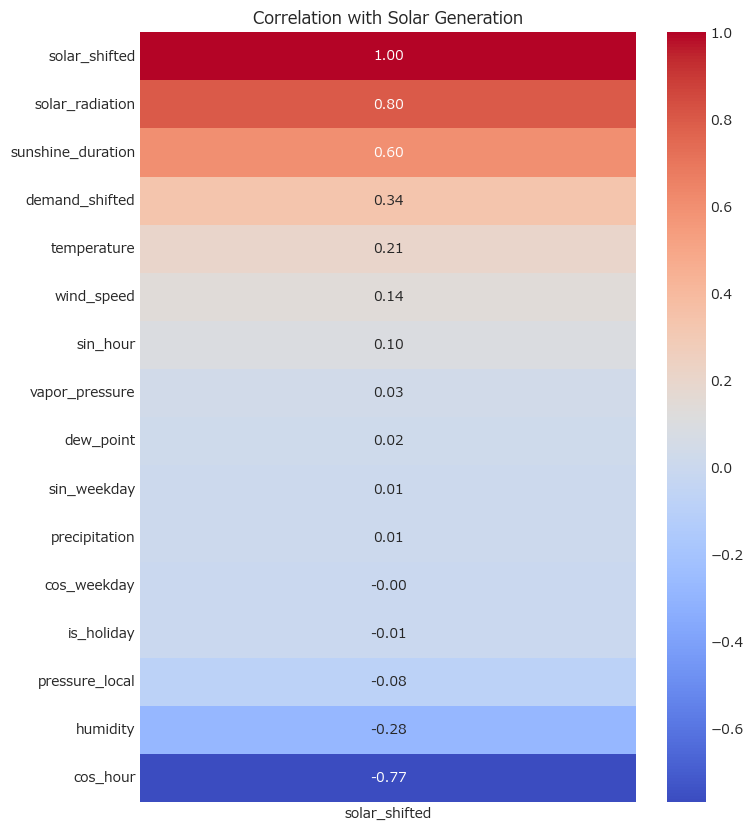

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# From here, the main subject is df_shifted
df = df_shifted.copy()

# === Correlation Heatmap ===
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,10))
sns.heatmap(
 corr[['solar_shifted']].sort_values(by='solar_shifted', ascending=False),
 annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Correlation with Solar Generation")
plt.show()

**Result**: As expected, power generation (`solar_gen_mw`) showed an extremely strong positive correlation (0.80 and 0.60 respectively) with "global solar radiation (`solar_radiation`)" and "sunshine duration (`sunshine_duration`)". Additionally, a strong negative correlation (-0.77) was also observed with "`cos_hour`".

#### 6-3-1-2. Variable Selection using LASSO Regression

Since correlation analysis can only evaluate one-to-one relationships between variables, we will next use LASSO regression to evaluate the contribution of all variables when included. As the data is time-series, `TimeSeriesSplit` will be used for cross-validation, taking care to prevent future data from being used to train on past data.

solar_radiation      3064.424360
cos_hour            -1618.063072
sunshine_duration    -828.325214
temperature          -319.541750
sin_hour              296.826612
pressure_local       -221.714901
precipitation         160.945518
humidity              108.149498
wind_speed            -63.877518
sin_weekday            17.005293
dtype: float64

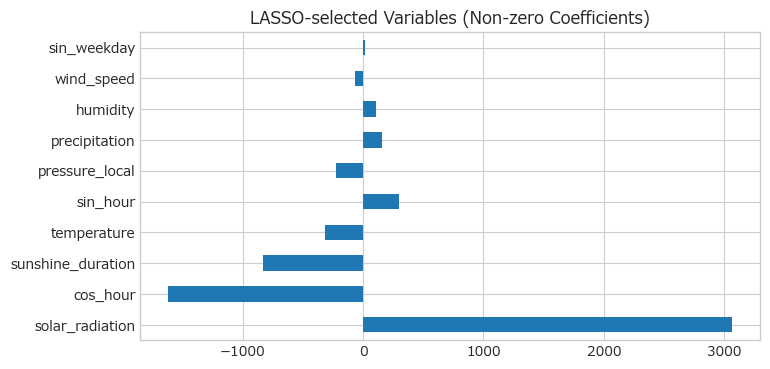

In [10]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# === Explanatory Variables (Example) ===
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["solar_shifted"]

# === Scaling and Training ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv, random_state=0).fit(X_scaled, y)

# === Coefficient Output ===
importance = pd.Series(lasso.coef_, index=feature_cols)
importance = importance[importance != 0].sort_values(key=abs, ascending=False)
display(importance)

plt.figure(figsize=(8,4))
importance.plot(kind='barh')
plt.title("LASSO-selected Variables (Non-zero Coefficients)")
plt.show()

**Result**: Variables whose coefficients were not set to zero by LASSO (i.e., deemed to contribute to the prediction) were selected. `solar_radiation` was shown to have the strongest positive influence, followed by `cos_hour`.

In [11]:
print(importance.index)

Index(['solar_radiation', 'cos_hour', 'sunshine_duration', 'temperature',
       'sin_hour', 'pressure_local', 'precipitation', 'humidity', 'wind_speed',
       'sin_weekday'],
      dtype='object')


Variables whose coefficients did not become zero due to LASSO (i.e., those deemed to contribute to the prediction) are listed.

#### 6-3-1-3. Visualization of LASSO's Regularization Path (Variable Selection Process)

This visualizes how `LassoCV` selected the optimal regularization strength ($\alpha$) through cross-validation (CV). This allows us to examine the trade-off between model complexity and prediction error.

-   **CV Curve**: Shows how the CV error (MSE) changes as $\alpha$ increases (regularization strengthens). The selected $\alpha$ is the point that minimizes this error.
-   **Sparsity Curve**: Shows how the number of features with non-zero coefficients decreases as $\alpha$ increases.

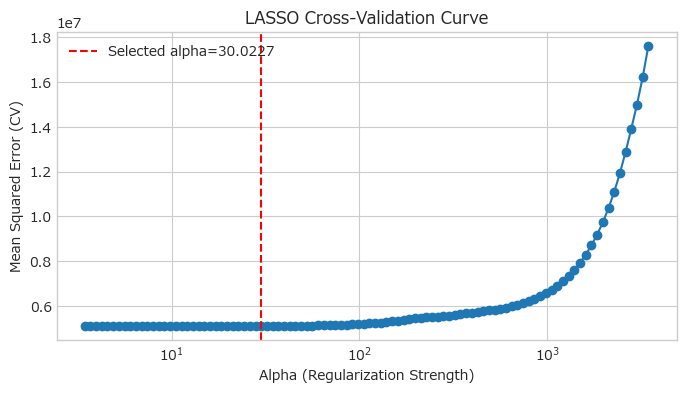

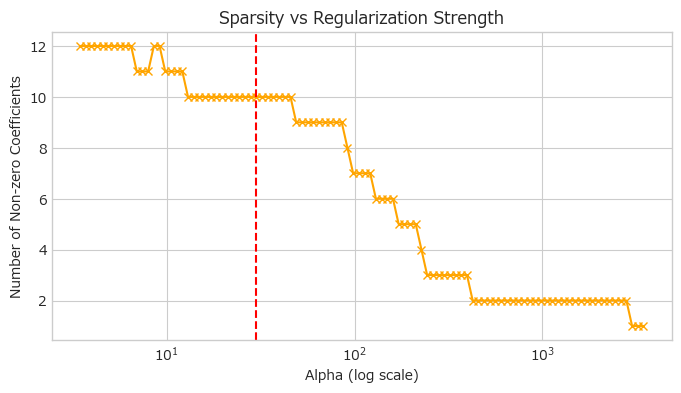

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# === Scaled Data ===
# feature_cols is assumed to be defined in the previous cell.
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["solar_shifted"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === LASSO CV using TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=5)
# Find the optimal alpha using LassoCV.
lasso_cv = LassoCV(cv=tscv, random_state=0, n_alphas=100).fit(X_scaled, y)

# === Visualization of alpha (lambda) and Mean Error ===
plt.figure(figsize=(8,4))
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), marker='o')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f"Selected alpha={lasso_cv.alpha_:.4f}")
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (CV)")
plt.title("LASSO Cross-Validation Curve")
plt.legend()
plt.grid(True)
plt.show()

# === Reference: Calculate coefficient paths for each alpha ===
# Use lasso_path to get the coefficient paths.
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=lasso_cv.alphas_)
nonzero_counts = (coefs != 0).sum(axis=0)
plt.figure(figsize=(8,4))
plt.plot(alphas, nonzero_counts, marker='x', color='orange')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Number of Non-zero Coefficients")
plt.title("Sparsity vs Regularization Strength")
plt.grid(True)
plt.show()

#### 6-3-1-4. Evaluation of Feature Importance using LightGBM + SHAP

LASSO is a variable selection method that assumes linearity. Therefore, we use SHAP to evaluate the impact of the variables selected by LASSO within a LightGBM model, which can also capture non-linear relationships. This makes it possible to intuitively understand whether each variable increases (red) or decreases (blue) the predicted value.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 39360, number of used features: 10
[LightGBM] [Info] Start training from score 2887.014990


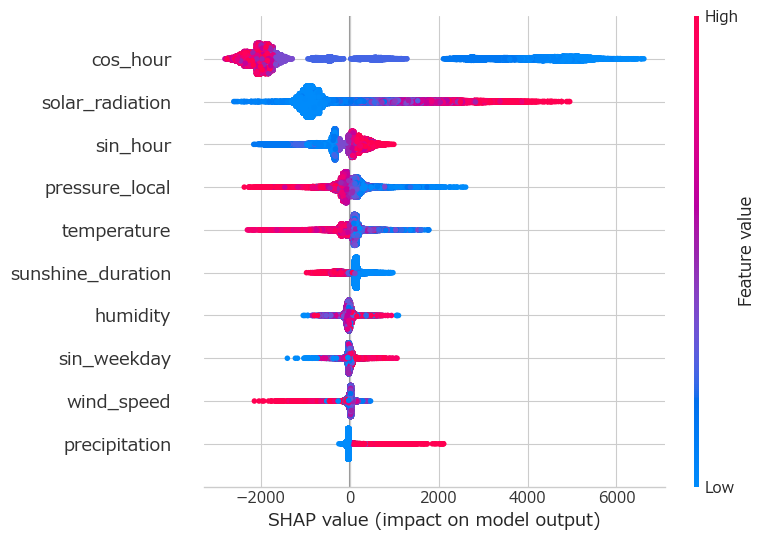

In [13]:
import pandas as pd
import lightgbm as lgb
import shap

# --- Modified Code ---

# === 1. Extracting only LASSO-selected features ===
# 'importance' is a Series of variables with non-zero coefficients
selected_features = importance.index.tolist()
X_sel = X[selected_features]

# === 2. Training the LightGBM model ===
model = lgb.LGBMRegressor(random_state=0)
model.fit(X_sel, y)

# === 3. SHAP Analysis and Visualization (Error-corrected version) ===
# Initialize the Explainer with only the model
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(X_sel)

# Display the SHAP summary plot
# This shows the magnitude and direction of each variable's impact on the predicted value
shap.summary_plot(shap_values, X_sel, show=True)

**Result**: The SHAP summary plot also confirms that `solar_radiation` is the most dominant feature. The larger the value (redder the color), the larger the SHAP value, strongly pushing up the predicted value.

The SHAP summary plot visualizes the magnitude and direction (positive/negative) of each variable's influence on the predicted value.

### 6-3-2. Feature Selection for Electricity Demand (`e_demand_mw`)

Next, we will change the target variable to "electricity consumption (`e_demand_mw`)" and perform feature selection using the same process as for solar power generation.

#### 6-3-2-1. Correlation Analysis

Electricity demand is expected to correlate with heating and cooling demand (temperature and humidity), time of day (`sin/cos_hour`), and day of the week or holidays (`is_holiday`).

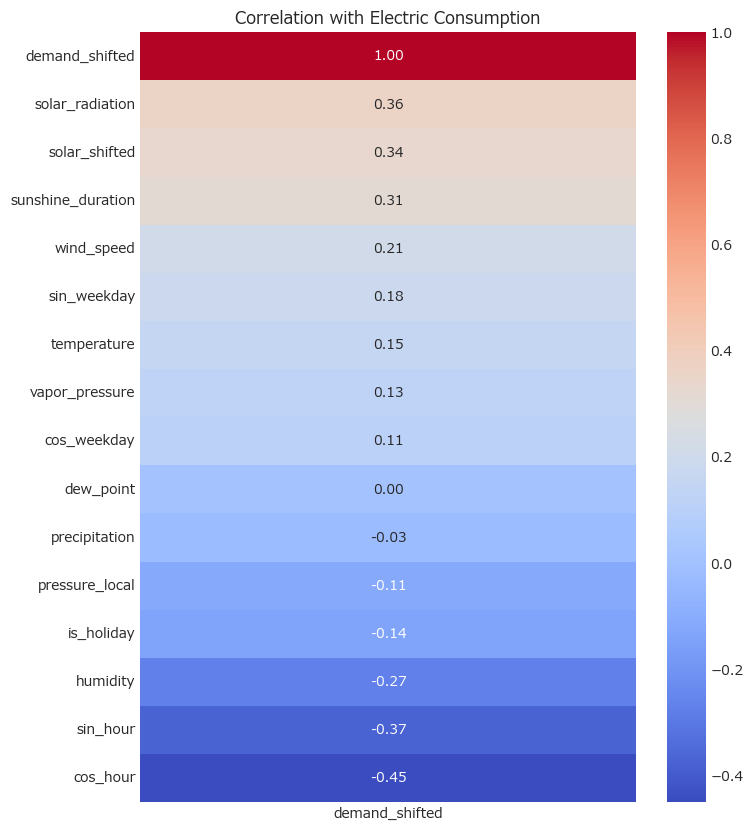

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# === Correlation Heatmap ===
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,10))
sns.heatmap(
 corr[["demand_shifted"]].sort_values(by="demand_shifted", ascending=False),
 annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Correlation with Electric Consumption")
plt.show()

**Result**: A positive correlation was observed with variables such as `solar_radiation` (total solar radiation), but the correlation was weaker than for power generation. Additionally, a negative correlation was observed with `cos_hour`, which indicates the activity period (low demand at night and high during the day).

#### 6-3-2-2. Variable Selection and $\alpha$ Tuning by LASSO Regression

Variable selection is performed for electricity demand as well, using `LassoCV` and `TimeSeriesSplit`.

cos_hour   -1352.649891
sin_hour    -803.857858
dtype: float64

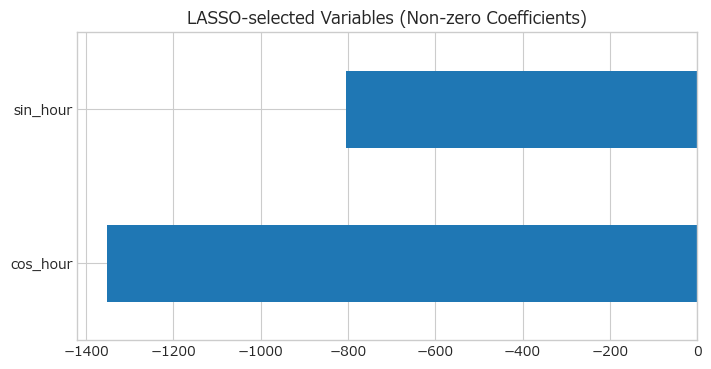

In [15]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# === Explanatory Variables (Example) ===
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["demand_shifted"]

# === Scaling and Training ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)
lasso = LassoCV(cv=tscv, random_state=0).fit(X_scaled, y)

# === Coefficient Output ===
importance = pd.Series(lasso.coef_, index=feature_cols)
importance = importance[importance != 0].sort_values(key=abs, ascending=False)
display(importance)

plt.figure(figsize=(8,4))
importance.plot(kind='barh')
plt.title("LASSO-selected Variables (Non-zero Coefficients)")
plt.show()

#### 6-3-2-3. LASSO Regularization Path Visualization and $\alpha$ Adjustment

The results of automatic selection by `LassoCV` suggested that the number of selected variables became extremely small, potentially leading to insufficient model expressiveness. This can occur when the CV error curve is unstable.

In such cases, it is effective for the analyst to adjust $\alpha$ by considering domain knowledge and the trade-off between error and the number of variables, rather than rigidly adhering to the automatically selected $\alpha$. Here, to achieve a low CV error while retaining more variables in the model, we manually set $\alpha$ to a smaller value (`alpha_new = 30`) and reconstruct the LASSO model. This approach aims to compensate for the limitations of mechanical optimization and obtain a more realistic set of features.

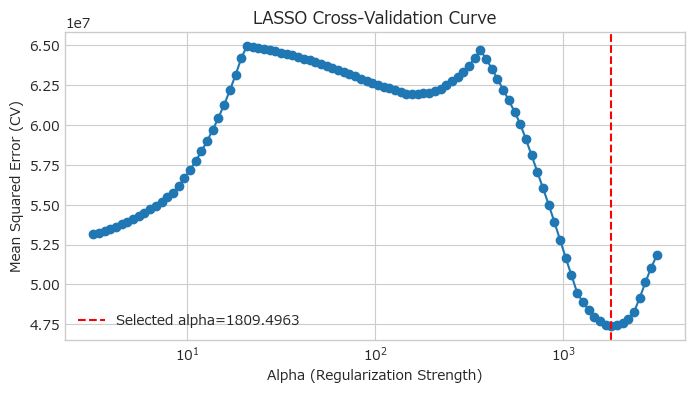

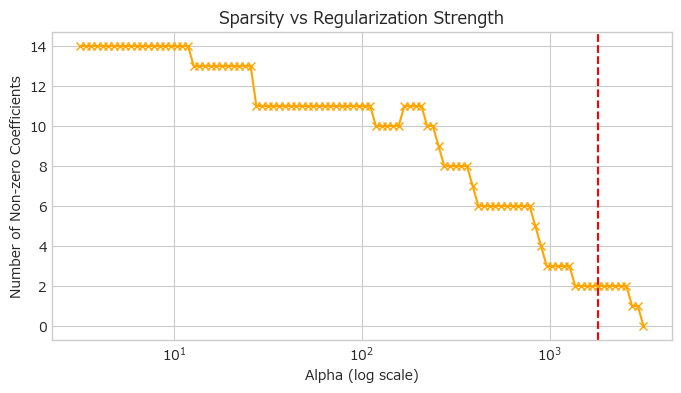

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# === Scaled Data ===
# feature_cols is assumed to be defined in the previous cell.
feature_cols = [
 "pressure_local","precipitation","temperature","dew_point","vapor_pressure",
 "humidity","wind_speed","sunshine_duration","solar_radiation",
 "sin_hour","cos_hour","sin_weekday","cos_weekday","is_holiday"
]
X = df[feature_cols]
y = df["demand_shifted"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === LASSO CV using TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=5)
# Find the optimal alpha with LassoCV
lasso_cv = LassoCV(cv=tscv, random_state=0, n_alphas=100).fit(X_scaled, y)

# === Visualization of alpha (lambda) and Mean Error ===
plt.figure(figsize=(8,4))
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=-1), marker='o')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f"Selected alpha={lasso_cv.alpha_:.4f}")
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (CV)")
plt.title("LASSO Cross-Validation Curve")
plt.legend()
plt.grid(True)
plt.show()

# === Reference: Calculate coefficient paths for each alpha ===
# Use lasso_path to get the coefficient paths
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=lasso_cv.alphas_)
nonzero_counts = (coefs != 0).sum(axis=0)
plt.figure(figsize=(8,4))
plt.plot(alphas, nonzero_counts, marker='x', color='orange')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Number of Non-zero Coefficients")
plt.title("Sparsity vs Regularization Strength")
plt.grid(True)
plt.show()

In [17]:
# After running LassoCV
# lasso.alphas_ : All candidate alpha values used for cross-validation
# lasso.mse_path_ : Cross-validation MSE for each alpha (n_splits x n_alphas array)

# Calculate the average MSE for each alpha (since n_splits=5, it's the average of 5 MSEs)
mean_mse = lasso.mse_path_.mean(axis=1)

# Alpha where MSE is minimized (automatically selected alpha)
alpha_auto = lasso.alpha_
print(f"Automatically selected alpha: {alpha_auto:.4f}")

# (Note) Select new alpha candidates from alphas_ that you want to check manually.
# For example, find an alpha that is smaller than the automatically selected alpha=1809 and near the valley of the graph.
# Sorting lasso.alphas_ in descending order will result in an order from right to left on the graph (from larger alpha to smaller alpha).

Automatically selected alpha: 1809.4963


In [18]:
# New alpha value to try
alpha_new = 30
print(f"New alpha to try: {alpha_new}")

New alpha to try: 30


vapor_pressure     13986.380681
temperature       -11511.543391
humidity           -4880.115569
sin_hour           -3009.318870
cos_hour           -2863.995630
solar_radiation     1102.057114
sin_weekday          895.247710
cos_weekday          877.602887
is_holiday          -483.229914
pressure_local      -153.661635
precipitation       -122.325570
dtype: float64

Number of variables remaining with manual selection (alpha=30): 11


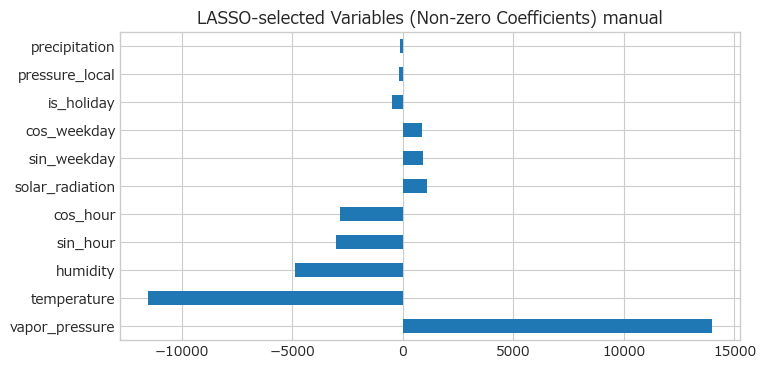

In [19]:
from sklearn.linear_model import Lasso
import pandas as pd 

# --- Model Rebuilding ---
# Manually fix alpha at 30
lasso_manual = Lasso(alpha=alpha_new, random_state=0) 
lasso_manual.fit(X_scaled, y)

# --- Output Coefficients ---
importance_manual = pd.Series(lasso_manual.coef_, index=feature_cols)

# Select only variables with non-zero coefficients
importance_manual = importance_manual[importance_manual != 0].sort_values(key=abs, ascending=False)
display(importance_manual)

# --- Check the number of variables ---
print(f"Number of variables remaining with manual selection (alpha={alpha_new}): {len(importance_manual)}")

# --- Display Graph ---
plt.figure(figsize=(8,4))
importance_manual.plot(kind='barh')
plt.title("LASSO-selected Variables (Non-zero Coefficients) manual")
plt.show()

In [20]:
print(importance_manual.index)

Index(['vapor_pressure', 'temperature', 'humidity', 'sin_hour', 'cos_hour',
       'solar_radiation', 'sin_weekday', 'cos_weekday', 'is_holiday',
       'pressure_local', 'precipitation'],
      dtype='object')


#### 6-3-2-4. Evaluation of Feature Importance using LightGBM + SHAP

Using the feature set selected by LASSO with a manually tuned $\alpha$, we will perform an influence assessment using LightGBM and SHAP.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 39360, number of used features: 11
[LightGBM] [Info] Start training from score 32039.445376


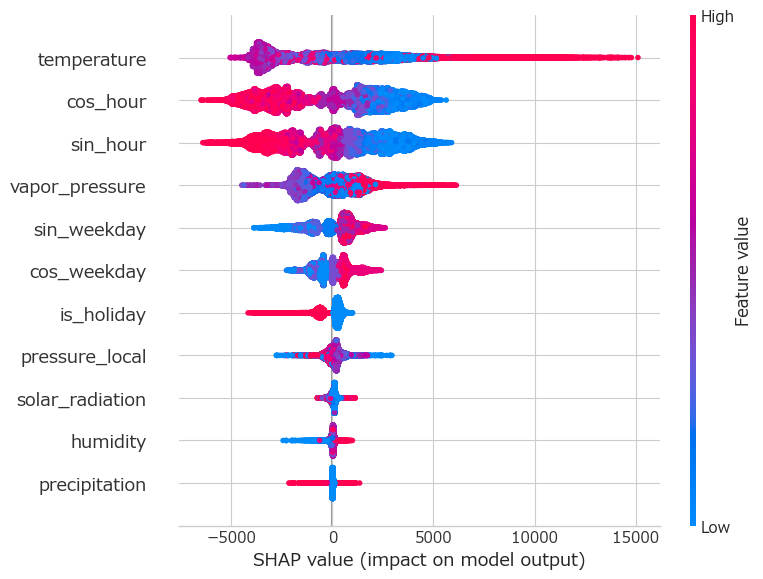

In [21]:
import pandas as pd
import lightgbm as lgb
import shap

# === 1. Extract only features selected by LASSO ===
# importance is a Series of variables with non-zero coefficients
selected_features = importance_manual.index.tolist()
X_sel = X[selected_features]

# === 2. LightGBM model training ===
model = lgb.LGBMRegressor(random_state=0)
model.fit(X_sel, y)

# === 3. SHAP analysis and visualization (error-corrected version) ===
# Initialize the Explainer with only the model
explainer = shap.Explainer(model)

# Calculate SHAP values
shap_values = explainer(X_sel)

# Display the SHAP summary plot
# This shows the magnitude and direction of each variable's impact on the predicted value
shap.summary_plot(shap_values, X_sel, show=True)

## 6-4. Conclusion

Based on the feature selection (LASSO + SHAP) conducted in this notebook, the following variables were determined to be effective as explanatory variables for each target variable.

#### 1. Key Explanatory Variables for Solar Power Generation (solar_gen_mw)

(In order of decreasing absolute LASSO coefficient)
* `solar_radiation` (Global Solar Radiation)
* `cos_hour` (Time of Day)
* `sunshine_duration` (Sunshine Duration)
* `temperature` (Air Temperature)
* `sin_hour` (Time of Day)
* `pressure_local` (Local Pressure)
* `precipitation` (Precipitation)
* `humidity` (Humidity)
* `wind_speed` (Wind Speed)
* `sin_weekday` (Day of Week)

**Analysis**:
Since solar power generation directly follows physical laws, `solar_radiation` (Global Solar Radiation) emerged as the overwhelmingly important feature. Additionally, `cos_hour` and `sunshine_duration` also strongly contributed as proxy variables for the presence and duration of sunlight, making this an extremely intuitive and reasonable result.

#### 2. Key Explanatory Variables for Electricity Consumption (e_demand_mw)

(In order of decreasing absolute LASSO coefficient with manual selection $\alpha=30$)
* `vapor_pressure` (Vapor Pressure)
* `temperature` (Air Temperature)
* `humidity` (Humidity)
* `sin_hour` (Time of Day)
* `cos_hour` (Time of Day)
* `solar_radiation` (Global Solar Radiation)
* `sin_weekday` (Day of Week)
* `cos_weekday` (Day of Week)
* `is_holiday` (Holiday Flag)
* `pressure_local` (Local Pressure)
* `precipitation` (Precipitation)

**Analysis**:
Electricity demand involves more complex factors, as it stems from human activities and comfort.
- **HVAC Demand**: The selection of `temperature` (Air Temperature) and `humidity` (Humidity) among the top variables indicates that heating, ventilation, and air conditioning (HVAC) is a major driver of electricity demand.
- **Importance of Vapor Pressure**: `vapor_pressure` (Vapor Pressure) was selected as the most important variable. Vapor pressure is "the partial pressure of water vapor in the air" and is an indicator that includes information about both temperature and humidity. Since it strongly correlates with perceived temperature and discomfort index, it is likely more strongly linked to electricity demand (especially for cooling) than simple temperature or humidity, serving as an indicator closer to human sensation like "muggy heat" or "dryness."
- **Life Cycle**: The selection of `sin/cos_hour` (Time of Day), `is_holiday` (Holiday Flag), and `sin/cos_weekday` (Day of Week) confirms that people's daily lives and economic activity cycles are indispensable factors in shaping electricity demand patterns.

#### Implications for the Next Step
The feature set selected in this step showed a strong correlation with the target variables from both physical and human factors. In the next step, we will use these variables to build a gradient boosting model such as LightGBM and evaluate and validate the final prediction accuracy.